## Yield Spread model
This notebook implements a model to predict yield spreads from reference and trade history data. The model uses an attention layer to extract information from the sequence of trades.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns


from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os

import wandb
from wandb.keras import WandbCallback


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data

Extension horovod.torch has not been built: /opt/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
tf.__version__

'2.7.0'

Setting the seed for layer initializer. We want the layers to be initialized with the same values to make the experiments deterministic

In [3]:
layer_initializer = initializers.RandomNormal(mean=0.0, stddev=0.1, seed=10)

Setting the environment variables

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="eng-reactor-287421-112eb767e1b3.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Initializing BigQuery client

In [5]:
bq_client = bigquery.Client()

Initializing GCP storage client

In [6]:
storage_client = storage.Client()

Declaring hyper-parameters

In [7]:
TRAIN_TEST_SPLIT = 0.85
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000
NUM_EPOCHS = 100

DROPOUT = 0.01
SEQUENCE_LENGTH = 5
NUM_FEATURES = 5

#### Initializing Wandb

In [8]:
# wandb.init(project="yield_spread_model", entity="ficc-ai", name="Encoding_experiments")

#### Query to fetch data

We create the training data from the trades which occurred between July and October 2021. All three trade directions, namely dealer-dealer (D), dealer-sells (S), and dealer-purchases (P) are included. We are limiting the training to bonds whose yield is a positive number less than three. The maturity description code is restricted to 2, to remove all muni derivatives.



In [9]:
DATA_QUERY = ''' 
SELECT
  *
FROM
  `eng-reactor-287421.auxiliary_views.materialized_trade_history`
WHERE
  yield IS NOT NULL
  AND yield > 0
  AND par_traded >= 10000
  AND trade_date >= '2021-04-29'
  --AND trade_date <= '2022-03-23'
  AND maturity_description_code = 2
  AND coupon_type in (8, 4, 10)
  AND capital_type <> 10
  AND default_exists <> TRUE
  AND sale_type <> 4
  AND sec_regulation IS NULL
  AND most_recent_default_event IS NULL
  AND default_indicator IS FALSE
  AND DATETIME_DIFF(trade_datetime,recent[SAFE_OFFSET(0)].trade_datetime,SECOND) < 1000000 -- 12 days to the most recent trade
  AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
ORDER BY
  trade_datetime DESC ''' 

In [10]:
# DATA_QUERY = ''' 
# SELECT
#   *
# FROM
#   `eng-reactor-287421.auxiliary_views.materialized_trade_history`
# WHERE
#   yield IS NOT NULL
#   AND yield > 0
#   AND par_traded >= 10000
#   AND trade_date >= '2021-08-01'
#   AND trade_date <= '2022-03-23'
#   AND maturity_description_code = 2
#   AND (coupon_type = 8 OR coupon_type = 4 OR coupon_type = 10)
#   AND capital_type <> 10
#   AND default_exists <> TRUE
#   AND sale_type <> 4
#   AND sec_regulation IS NULL
#   AND most_recent_default_event IS NULL
#   AND default_indicator IS FALSE
#   AND DATETIME_DIFF(trade_datetime,recent[SAFE_OFFSET(0)].trade_datetime,SECOND) < 1000000 -- 12 days to the most recent trade
#   AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
#   AND (purpose_sub_class is null or 
#        purpose_sub_class <> 6 or 
#        purpose_sub_class <> 20 or 
#        purpose_sub_class <> 21 or 
#        purpose_sub_class <> 22 or 
#        purpose_sub_class <> 57 or 
#        purpose_sub_class <> 44 or 
#        purpose_sub_class <> 106)
#  AND (called_redemption_type is null or called_redemption_type <> 18 or called_redemption_type <> 19)
# ORDER BY
#   trade_datetime DESC ''' 

#### Data Preparation
We grab the data from BigQuery and convert it into a format suitable for input to the model. We save the processed data as a pickle file on a GCP bucket.

The trade history is an array which contains the yield spread, trade type, trade size, and the number of seconds ago the trade occured. 

In [11]:
%%time
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
# with fs.open('ficc_models_training_data/processed_data_ficc_2022_trades_min_trades_in_hist_0_2022-05-23-04:28.pkl') as f:
with fs.open('ficc_training_data_latest/processed_data.pkl') as f:
    data = pd.read_pickle(f)

CPU times: user 18.4 s, sys: 7.91 s, total: 26.3 s
Wall time: 50.7 s


#### Additionals exclusion we are working on. This is to eliminate weird cusips

In [13]:
data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
data = data[data.sinking == False]
data = data[data.incorporated_state_code != 'VI']
data = data[data.coupon_type == 8]
data = data[data.is_called == False]

In [14]:
processed_data = data[IDENTIFIERS + PREDICTORS + ['dollar_price','calc_date', 'trade_date','trade_datetime', 'purpose_sub_class', 'called_redemption_type', 'calc_day_cat']]

In [15]:
del data

In [16]:
# processed_data = processed_data[processed_data.trade_date > '11-01-2021']

### Adding target trade features to calculate attention

As a first step, we only utilize the size of the trade and the directions as features to calculate the attention. Going forward we will be adding more features like the state code, coupon, interest payment frequency, etc. 

In [17]:
trade_mapping = {'D':[0,0], 'S':[0,1], 'P':[1,0]}
def target_trade_processing_for_attention(row):
    target_trade_features = []
    target_trade_features.append(row['quantity'])
    target_trade_features = target_trade_features + trade_mapping[row['trade_type']]
    return np.tile(target_trade_features, (5,1))

In [18]:
%%time
processed_data['target_attention_features'] = processed_data.apply(target_trade_processing_for_attention, axis = 1)

CPU times: user 1min 53s, sys: 1.11 s, total: 1min 54s
Wall time: 1min 54s


#### Concatenating the trade history and target attention features

In [19]:
processed_data['concatenated_trade_history'] = processed_data.apply(lambda x: np.concatenate((x['trade_history'], x['target_attention_features']), axis=1), axis=1)

For the purpose of plotting, not used in training

In [20]:
processed_data.purpose_sub_class.fillna(0, inplace=True)

In [21]:
np.unique(processed_data.rating)

array(['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB',
       'BB+', 'BB-', 'BBB', 'BBB+', 'BBB-', 'CCC', 'CCC+', 'MR', 'NR'],
      dtype=object)

Selecting a subset of features that will be used to train on.

In [22]:
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')

In [23]:
# processed_data = data[IDENTIFIERS + PREDICTORS + ['dollar_price','calc_date', 'trade_date','trade_datetime', 'purpose_sub_class', 'called_redemption_type', 'calc_day_cat']]

These sub classes are associated with junk bonds. We drop them for now.

In [24]:
processed_data = processed_data[~processed_data.purpose_sub_class.isin([6, 20, 21, 22, 44, 57, 90, 106])]

In [25]:
processed_data = processed_data[~processed_data.called_redemption_type.isin([18, 19])]

In [26]:
len(processed_data)

2401543

In [27]:
np.unique(processed_data.rating)

array(['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB',
       'BB+', 'BB-', 'BBB', 'BBB+', 'BBB-', 'CCC', 'MR', 'NR'],
      dtype=object)

#### Fitting encoders to the categorical features. These encoders are then used to encode the categorical features of the train and test set

In [29]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

In [30]:
upload_data(storage_client, 'ficc_training_data_latest', f"encoders.pkl")

File encoders.pkl uploaded to ficc_training_data_latest.


#### Splitting the data into train and test sets



In [31]:
len(processed_data)

2401543

In [32]:
train_dataframe = processed_data[processed_data.trade_date < '05-01-2022']

In [33]:
test_dataframe = processed_data[(processed_data.trade_date >= '05-01-2022')]

In [34]:
len(train_dataframe)

1846402

In [35]:
len(test_dataframe)

555141

In [36]:
# train_index = int(len(processed_data) * (1-TRAIN_TEST_SPLIT))
# train_dataframe = processed_data[train_index:]
# # train_security_descrip = security_description_vectorized[train_index:]
# # train_org_primary = organization_primary_vectorized[train_index:]

# test_dataframe = processed_data[:train_index]
# # test_security_descrip = security_description_vectorized[:train_index]
# # test_org_primary = organization_primary_vectorized[:train_index]
# print(f'Print length of training data frame {len(train_dataframe)}')
# print(f'Pring length of testing data frame {len(test_dataframe)}')

Converting data into format suitable for the model

In [42]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['concatenated_trade_history'].to_numpy()))
    
    #datalist.append(np.stack(df['trade_history'].to_numpy()))
    #datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [43]:
%%time
x_train = create_input(train_dataframe)
y_train = train_dataframe.yield_spread

CPU times: user 4 s, sys: 155 ms, total: 4.16 s
Wall time: 4.15 s


In [44]:
%%time
x_test = create_input(test_dataframe)
y_test = test_dataframe.yield_spread

CPU times: user 1.35 s, sys: 31.9 ms, total: 1.39 s
Wall time: 1.39 s


In [45]:
x_train[1].shape

(1846402, 26)

In [46]:
x_test[2].shape

(555141,)

#### Adapting Normalization layers to the non categorical features

In [47]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization(name='Trade_history_normalizer')
trade_history_normalizer.adapt(x_train[0])

In [48]:
# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[1])

#### Setting the seed for the model

In [49]:
tf.keras.utils.set_random_seed(10)

#### Non-linear encoding block

In [51]:
class NonLinearEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_units_layer_1, hidden_units_layer_2):
        super(NonLinearEncodingLayer, self).__init__()

        self.layer1 = layers.Dense(hidden_units_layer_1,
                                  activation='relu',
                                  name="encoding_layer_1")
        
        self.layer2 = layers.Dense(hidden_units_layer_2,
                                   activation='relu',
                                  name="encoding_layer_2")

    def call(self, concatinated_trade_history):
        return(self.layer2(self.layer1(concatinated_trade_history)))

#### Attention layer
This is an implementation of a layer that calculates scaled dot product attention. 

In [52]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, depth):
        super(CustomAttention, self).__init__()
        self.depth = depth
        self.wq = layers.Dense(depth,
                               name='weights_query') 
        self.wk = layers.Dense(depth,
                               name='weights_key')
        self.wv = layers.Dense(depth,
                               name='weights_value')

    def scaled_dot_product_attention(self, q, v, k):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        scaling = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(scaling)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=1) 
        output = tf.matmul(attention_weights, v)
        
        return output
    
    def call(self, q, v, k):
        
        q = self.wq(q)
        v = self.wv(v)
        k = self.wk(k)

        output = self.scaled_dot_product_attention(q, v, k)
        
        return output    

#### Implementation of the model

In [53]:
inputs = []
layer = []

############## INPUT BLOCK ###################
# trade_history_input = layers.Input(name="trade_history_input", 
#                                    shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
#                                    dtype = tf.float32) 

# target_attention_input = layers.Input(name="target_attention_input", 
#                                    shape=(SEQUENCE_LENGTH, 3), 
#                                    dtype = tf.float32) 

concatenated_trade_history_input = layers.Input(name="concatenated_trade_history", 
                                   shape=(SEQUENCE_LENGTH, 8), 
                                   dtype = tf.float32) 

inputs.append(concatenated_trade_history_input)

inputs.append(layers.Input(
    name="NON_CAT_AND_BINARY_FEATURES",
    shape=(len(NON_CAT_FEATURES + BINARY),)
))


layer.append(noncat_binary_normalizer(inputs[1]))
####################################################


############## TRADE HISTORY MODEL #################

# Declaring a instance of the custom attention layer 
non_linear_encoding_layer = NonLinearEncodingLayer(100,30)
attention_layer = CustomAttention(50)

features = non_linear_encoding_layer(trade_history_normalizer(inputs[0]))
features = attention_layer(features, features, features)
features = layers.Flatten(name = "attention_flat")(features)
trade_history_output = layers.Dense(100, 
                                    activation='relu',
                                    kernel_initializer=layer_initializer)(features)

####################################################

############## REFERENCE DATA MODEL ################
global encoders
for f in CATEGORICAL_FEATURES:
    fin = layers.Input(shape=(1,), name = f)
    inputs.append(fin)
    embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                    output_dim = int(np.sqrt(fmax[f])),
                                                                    input_length= 1,
                                                                    name = f + "_embed",
                                                                    embeddings_initializer=layer_initializer)(fin))
    layer.append(embedded)

    
reference_hidden = layers.Dense(400,activation='relu',kernel_initializer=layer_initializer,name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

reference_hidden = layers.BatchNormalization()(reference_hidden)
reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

reference_hidden2 = layers.Dense(200,activation='relu',kernel_initializer=layer_initializer,name='reference_hidden_2')(reference_hidden)
reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

reference_output = layers.Dense(100,activation='tanh',kernel_initializer=layer_initializer,name='reference_hidden_3')(reference_hidden2)

####################################################

feed_forward_input = layers.concatenate([reference_output, trade_history_output])

hidden = layers.Dense(300,activation='relu',kernel_initializer=layer_initializer)(feed_forward_input)
hidden = layers.BatchNormalization()(hidden)
hidden = layers.Dropout(DROPOUT)(hidden)

hidden2 = layers.Dense(100,activation='tanh',kernel_initializer=layer_initializer)(hidden)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(DROPOUT)(hidden2)

final = layers.Dense(1,kernel_initializer=layer_initializer)(hidden2)

model = keras.Model(inputs=inputs, outputs=final)

In [54]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rating (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 incorporated_state_code (Input  [(None, 1)]         0           []                               
 Layer)                                                                                           
                                                                                                  
 trade_type (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 purpose_class (InputLayer)     [(None, 1)]          0           []                           

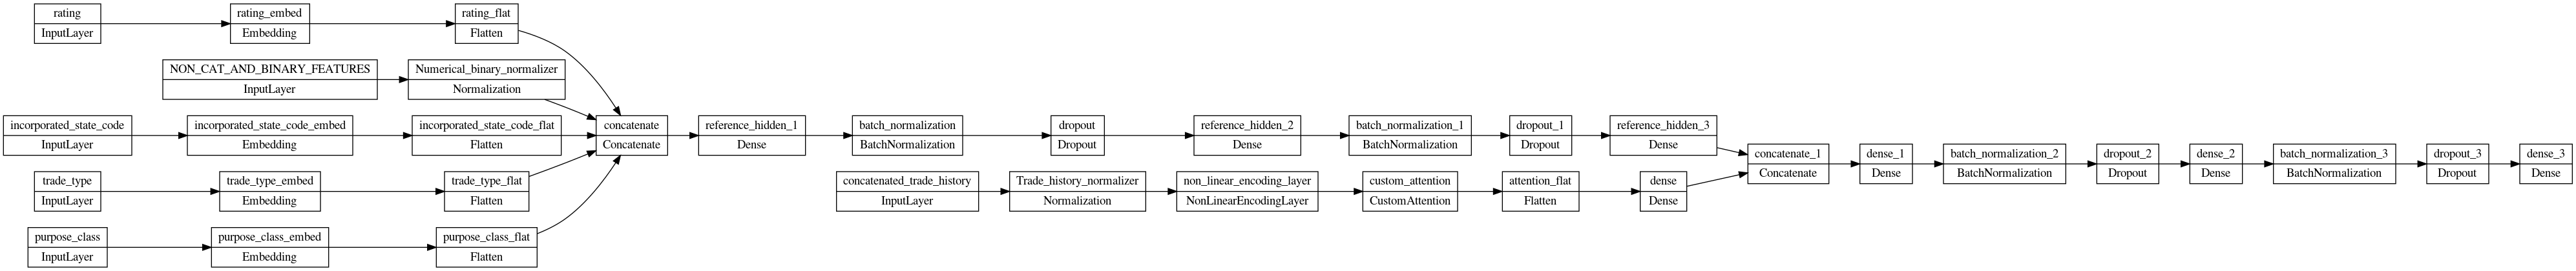

In [55]:
tf.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="LR",
    expand_nested=False,
    dpi=96,
)

In [58]:
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [59]:
fit_callbacks = [
#     WandbCallback(),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True,
    ),
    time_callback
]

In [60]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
          loss=keras.losses.MeanAbsoluteError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

In [61]:
%time history = model.fit(x_train,y_train,epochs=100,batch_size=BATCH_SIZE,verbose=1,validation_split=0.1,callbacks=fit_callbacks)

Epoch 1/100
1662/1662 [==============================] - 16s 8ms/step - loss: 39.6108 - mean_absolute_error: 39.6108 - val_loss: 30.7342 - val_mean_absolute_error: 30.7342
Epoch 2/100
1662/1662 [==============================] - 13s 8ms/step - loss: 28.0207 - mean_absolute_error: 28.0207 - val_loss: 17.7405 - val_mean_absolute_error: 17.7405
Epoch 3/100
1662/1662 [==============================] - 14s 8ms/step - loss: 13.2492 - mean_absolute_error: 13.2492 - val_loss: 7.4361 - val_mean_absolute_error: 7.4361
Epoch 4/100
1662/1662 [==============================] - 13s 8ms/step - loss: 8.8917 - mean_absolute_error: 8.8917 - val_loss: 6.8769 - val_mean_absolute_error: 6.8769
Epoch 5/100
1662/1662 [==============================] - 13s 8ms/step - loss: 8.6538 - mean_absolute_error: 8.6538 - val_loss: 6.8968 - val_mean_absolute_error: 6.8968
Epoch 6/100
1662/1662 [==============================] - 13s 8ms/step - loss: 8.5444 - mean_absolute_error: 8.5444 - val_loss: 6.8600 - val_mean_absol

### Test accuracy on the entire test set

Accuracy with the recurrent network and attention (concatenated trade hist) was 11.12

Accuracy with just attention is 11.25

This indicates that the recurrent network is learning but is not learning sufficiently.

In [62]:
_, mae = model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {round(mae, 3)}")
# wandb.log({"Test MAE": mae})

17349/17349 [==============================] - 53s 3ms/step - loss: 11.2550 - mean_absolute_error: 11.2550
Test loss: 11.255


#### Plotting validation loss vs training loss

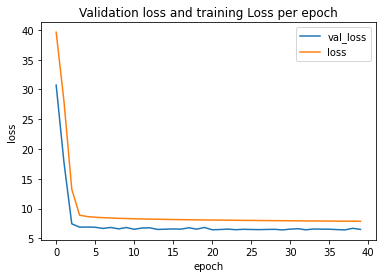

In [84]:
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.title('Validation loss and training Loss per epoch')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Accuracy on a daily basis

Measuring the daily accuracy for large dealer dealer trades

In [67]:
for d in [d for d in pd.date_range(start="05/01/2022",end="05/31/2022",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d)
                              & (test_dataframe.trade_type == 'D')
                             & (test_dataframe.quantity >= np.log10(500000))].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day)  
    next_day_preds = model.predict(next_day_test)
    error = next_day.yield_spread - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    print(f"Date :{d.date()} MAE:{MAE}" )

Date :2022-05-02 MAE:6.542442446950354
Date :2022-05-03 MAE:7.254274036959757
Date :2022-05-04 MAE:8.000712623631566
Date :2022-05-06 MAE:10.821038398019175
Date :2022-05-09 MAE:8.114501817561372
Date :2022-05-10 MAE:8.711253449245648
Date :2022-05-11 MAE:9.863150106661163
Date :2022-05-12 MAE:8.477902984806006
Date :2022-05-13 MAE:10.219459864982715
Date :2022-05-16 MAE:6.839586411900688
Date :2022-05-17 MAE:7.943728192230303
Date :2022-05-18 MAE:9.80703762882959
Date :2022-05-19 MAE:8.100314375403077
Date :2022-05-20 MAE:10.848611914670055
Date :2022-05-23 MAE:8.560388233521184
Date :2022-05-24 MAE:10.536194601589651
Date :2022-05-25 MAE:11.017088870920295
Date :2022-05-26 MAE:7.817188952159622
Date :2022-05-27 MAE:12.61875914722302
Date :2022-05-31 MAE:12.224715982656837


### Test accuracy on large dealer-dealer trades
We define large as any trade which is above $500,000

Accuracy with the recurrent network and attention (concatenated trade history) was 9.6\
Accuracy with just attention is 9.75

This further indicates that the recurrent network is learning.

In [75]:
true_mid = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))] # & (test_dataframe.days_to_call >= np.log10(360))]

In [76]:
len(true_mid)

6193

In [77]:
%%time
x_true_mid = create_input(true_mid)
y_true_mid = true_mid.yield_spread

CPU times: user 23.8 ms, sys: 0 ns, total: 23.8 ms
Wall time: 23.2 ms


In [78]:
_, mae = model.evaluate(x_true_mid, y_true_mid, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

194/194 [==============================] - 1s 3ms/step - loss: 9.7570 - mean_absolute_error: 9.7570
Test MAE: 9.757


### Alternative evaluation set
Experiment with other conditions. From the error analysis notebook, it was observed that the number of accrued days that have passed since the beginning of interest being accrued is important

In [79]:
temp_test = test_dataframe[(test_dataframe['accrued_days'] < 200) & (test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(50000))]

In [80]:
len(temp_test)

7080

In [81]:
%%time
x_temp_test = create_input(temp_test)
y_temp_test = temp_test.yield_spread

CPU times: user 25.4 ms, sys: 0 ns, total: 25.4 ms
Wall time: 24.8 ms


In [82]:
_, mae = model.evaluate(x_temp_test, y_temp_test, verbose=1)
print(f"Test MAE: {round(mae, 3)}")

222/222 [==============================] - 1s 3ms/step - loss: 9.3507 - mean_absolute_error: 9.3507
Test MAE: 9.351


# Saving the model

In [68]:
file_timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M')

In [69]:
file_timestamp

'2022-05-26-10-54'

In [70]:
with open(f"encoders_{file_timestamp}.pkl",'wb') as file:
    pickle.dump(encoders,file)

In [71]:
f"saved_model_{file_timestamp}"

'saved_model_2022-05-26-10-54'

In [72]:
model.save(f"saved_model_{file_timestamp}")

INFO:tensorflow:Assets written to: saved_model_2022-05-26-10-54/assets


INFO:tensorflow:Assets written to: saved_model_2022-05-26-10-54/assets


In [73]:
import shutil
shutil.make_archive(f"model", 'zip', f"saved_model_{file_timestamp}")

'/home/shayaan/ficc/ml_models/sequence_predictors/model.zip'

In [74]:
upload_data(storage_client, 'ficc_encoders', f"encoders_{file_timestamp}.pkl")

File encoders_2022-05-26-10-54.pkl uploaded to ficc_encoders.


In [75]:
upload_data(storage_client, 'ficc_training_data_latest', f"model.zip")

File model.zip uploaded to ficc_training_data_latest.


### Plotting trades above a threshold

In [85]:
%time preds = model.predict(x_test)
preds = preds.reshape(len(preds))
error = test_dataframe.yield_spread - preds
MAE = np.mean(np.abs(error))
print(MAE)

CPU times: user 1min 8s, sys: 13.6 s, total: 1min 21s
Wall time: 41.8 s
11.254997581675713


Max prediction : 319.5290832519531 Min predicton: -66.30574035644531
Length of dataframe: 555141


<Figure size 432x288 with 0 Axes>

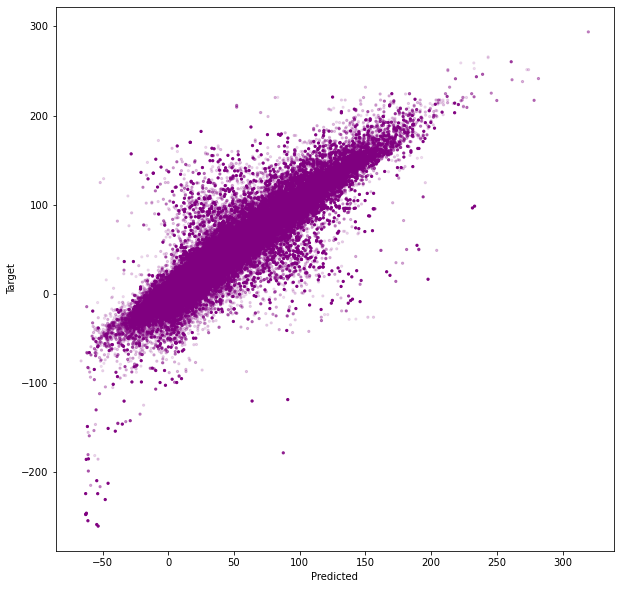

In [86]:
from matplotlib.colors import to_rgb, to_rgba
threshold = 1e6

# plot points with transparency depending on size of trade
def drawpoints(preds, target, dataframe):
    #Only draw Dealer-Dealer trades
    r, g, b = to_rgb('purple')
    keep = (10**dataframe.quantity > threshold/10)  # save time by not plotting points that would be invisible
    w = np.minimum( np.array(10**dataframe.quantity[keep]), threshold)
    opacity = w/threshold
    color = [(r, g, b, alpha) for alpha in opacity]
    
    print(f"Max prediction : {max(preds[keep])} Min predicton: {min(preds[keep])}")
    print(f"Length of dataframe: {len(dataframe)}")
    
    plt.figure(figsize=(10, 10))
    plt.scatter(preds[keep], target[keep], s=5, c=color)
    plt.xlabel('Predicted')
    plt.ylabel('Target')
    
plt.figure()
drawpoints(preds, test_dataframe.yield_spread, test_dataframe)

### Baseline using the last yield spread

16.633716694637375
Max prediction : 9710.43621521426 Min predicton: -288.0888749979444
Length of dataframe: 555141


<Figure size 432x288 with 0 Axes>

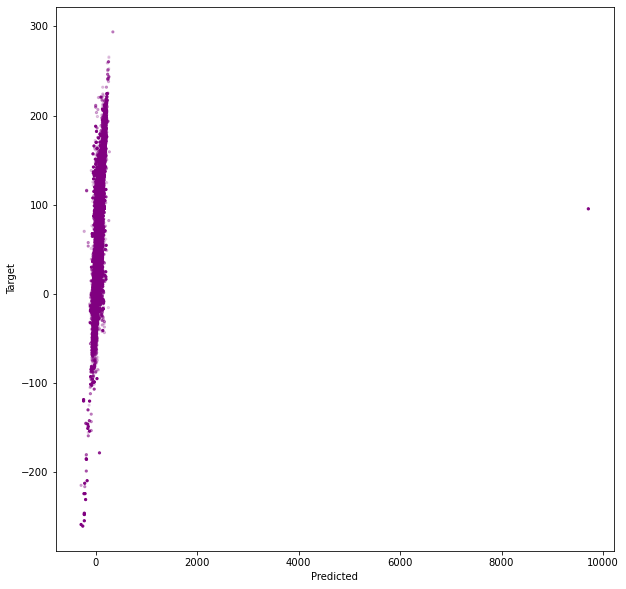

In [87]:
last_ys_preds = test_dataframe.last_yield_spread
error = test_dataframe.yield_spread - last_ys_preds

MAE = np.mean(np.abs(error))
print(MAE)

plt.figure()
drawpoints(last_ys_preds, test_dataframe.yield_spread, test_dataframe)

### Baseline using the last yield spread on dealer dealer true mid trades

11.471687694383272
Max prediction : 224.45460582602465 Min predicton: -224.0444373264511
Length of dataframe: 6193


<Figure size 432x288 with 0 Axes>

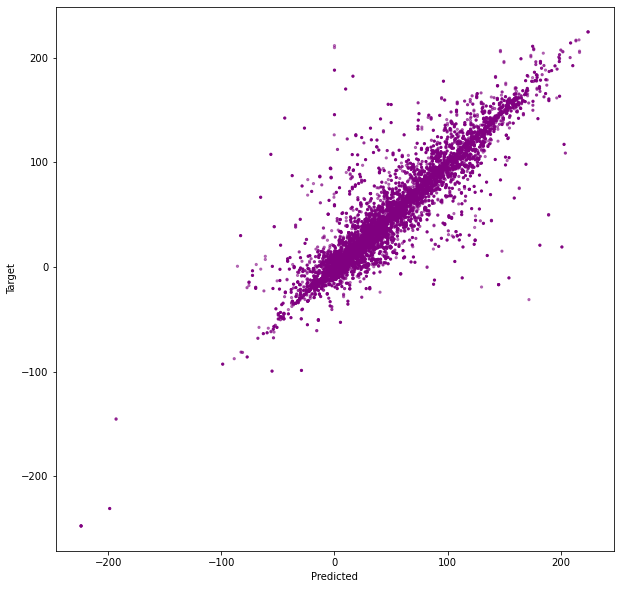

In [88]:
temp_test = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]
last_ys_preds = temp_test.last_yield_spread
error = temp_test.yield_spread - last_ys_preds

MAE = np.mean(np.abs(error))
print(MAE)

plt.figure()
drawpoints(last_ys_preds, temp_test.yield_spread, temp_test)

### Regression baseline using previous yield spread optimizing MSE

In [89]:
from sklearn.linear_model import LinearRegression

In [90]:
x = train_dataframe.last_yield_spread.values.reshape(-1,1)
y = train_dataframe.yield_spread

In [91]:
reg = LinearRegression().fit(x, y)

In [92]:
print(f"Regression coefficient {reg.coef_} Intercept {reg.intercept_}")

Regression coefficient [0.79533689] Intercept 5.772009236679068


In [93]:
predicted_ys = reg.predict(test_dataframe.last_yield_spread.values.reshape(-1,1))
actual_ys = test_dataframe.yield_spread.values

In [94]:
MAE = np.mean(np.abs(test_dataframe.yield_spread - predicted_ys))
print(MAE)

16.58307420939522


In [95]:
x_range = np.arange(-20,300)
y_straight = x_range.copy()
y_regression = reg.coef_ * x_range + reg.intercept_

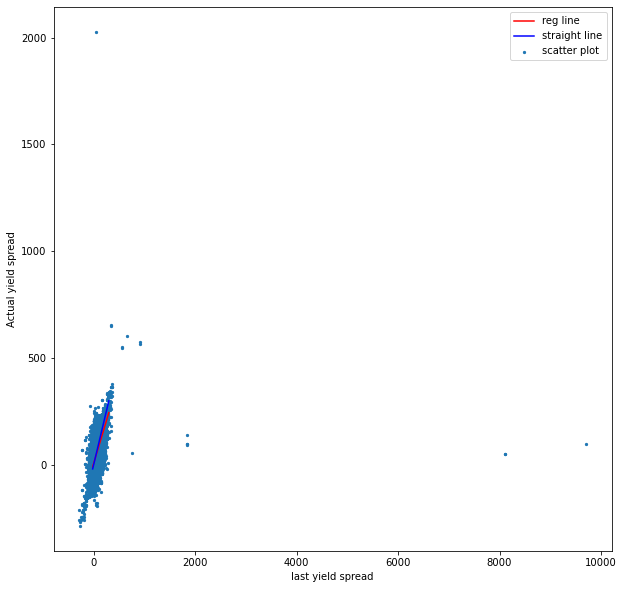

In [96]:
plt.figure(figsize=(10,10))
plt.scatter(test_dataframe.last_yield_spread, actual_ys, s=5)
plt.plot(x_range, y_regression, color='r')
plt.plot(x_range, y_straight, color='b')
plt.xlabel('last yield spread')
plt.ylabel('Actual yield spread')
plt.legend(['reg line','straight line','scatter plot'])
plt.show()

In [97]:
test_dataframe[test_dataframe.yield_spread > 1000][['cusip','trade_date','purpose_sub_class','yield_spread']]

,cusip,trade_date,purpose_sub_class,yield_spread
174059,34682HPS9,2022-06-01,129.0,2026.866157


### Regression baseline using previous yield spread optimizing MAE

In [98]:
from statsmodels.regression.quantile_regression import QuantReg

In [99]:
q_reg = QuantReg(train_dataframe.last_yield_spread, train_dataframe.yield_spread)

In [100]:
res = q_reg.fit(q=.5)

In [101]:
predicted_yield_spread = res.predict(test_dataframe.last_yield_spread)
actual_yiels_spread = test_dataframe.yield_spread.values

In [102]:
MAE = np.mean(np.abs(actual_yiels_spread - predicted_yield_spread))
print(MAE)

16.633727960045192


In [103]:
print(f'Regression coefficient {res.params[0]}')

Regression coefficient 1.000000624325274


In [104]:
y_mae_regression = res.params[0] * x_range

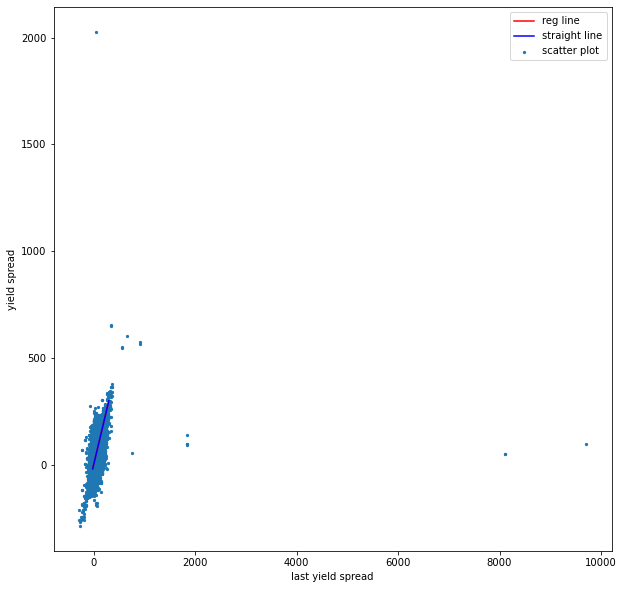

In [105]:
plt.figure(figsize=(10,10))
plt.scatter(test_dataframe.last_yield_spread, actual_yiels_spread, s=5)
plt.plot(x_range, y_mae_regression, color='r')
plt.plot(x_range, y_straight, color='b')
plt.xlabel('last yield spread')
plt.ylabel('yield spread')
plt.legend(['reg line','straight line','scatter plot'])
plt.show()

### LightGBM baseline

In [106]:
def gbmprep(df):
    df[CATEGORICAL_FEATURES ] = df[CATEGORICAL_FEATURES].astype('category')
    df[NON_CAT_FEATURES + BINARY] = df[NON_CAT_FEATURES + BINARY].astype('float64')
    df = df.drop(columns = ['trade_history','target_attention_features','yield_spread','calc_day_cat'])
    return df

In [107]:
trainlabel = train_dataframe.yield_spread
testlabel = test_dataframe.yield_spread

In [108]:
gbt_td = gbmprep(train_dataframe[PREDICTORS])

In [109]:
gbtmodel = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mae', verbosity=-1)

In [110]:
gbtmodel.fit(gbt_td, trainlabel) 

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(max_depth=12, num_iterations=300, num_leaves=300, objective='mae',
              verbosity=-1)

In [111]:
%%time 
gbt_pred = gbtmodel.predict( gbmprep(test_dataframe[PREDICTORS]) )
delta = testlabel - gbt_pred
print( delta.mean(), delta.abs().mean() )

-0.5702745954589951 13.996463294204634
CPU times: user 42 s, sys: 0 ns, total: 42 s
Wall time: 2.5 s


#### GBM true mid baseline

In [112]:
%%time 
gbt_pred = gbtmodel.predict(gbmprep(temp_test[PREDICTORS]) )
delta = temp_test.yield_spread - gbt_pred
print( delta.mean(), delta.abs().mean() )

-0.44804536109252496 13.83485860931933
CPU times: user 443 ms, sys: 0 ns, total: 443 ms
Wall time: 49.6 ms


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

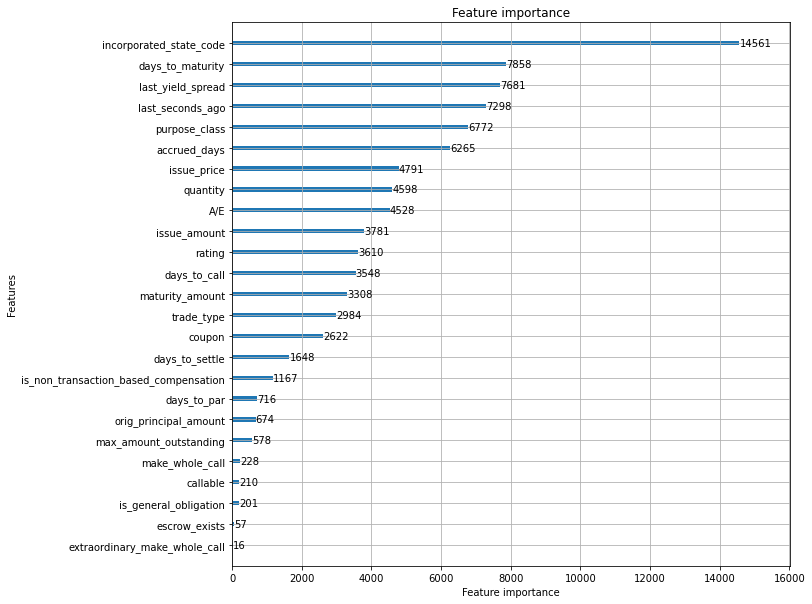

In [113]:
lightgbm.plot_importance(gbtmodel, figsize=(10,10))

#### Analyzing the test set

In [114]:
test_preds = model.predict(x_test)

In [115]:
len(test_preds)

555141

In [116]:
evaluation_dataframe = test_dataframe.copy()
evaluation_dataframe['predicted_yield_spreads'] = test_preds
evaluation_dataframe['delta_yield_spreads'] = evaluation_dataframe.yield_spread - evaluation_dataframe.predicted_yield_spreads

In [117]:
np.mean(evaluation_dataframe.delta_yield_spreads)

-0.22734716658279713

In [118]:
np.std(evaluation_dataframe.delta_yield_spreads)

17.994107002346905

array([[<AxesSubplot:title={'center':'delta_yield_spreads'}>]],
      dtype=object)

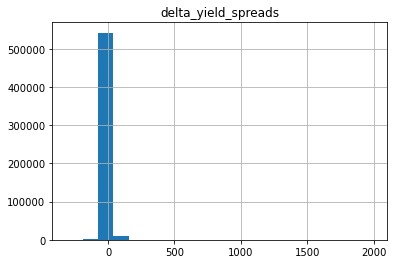

In [119]:
evaluation_dataframe.hist('delta_yield_spreads', bins=20)

In [120]:
evaluation_dataframe.days_to_maturity = 10**evaluation_dataframe.days_to_maturity
evaluation_dataframe.days_to_call = 10**evaluation_dataframe.days_to_call
evaluation_dataframe.quantity = 10**evaluation_dataframe.quantity
evaluation_dataframe.sort_values('delta_yield_spreads', ascending=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,target_attention_features,concatenated_trade_history,predicted_yield_spreads,delta_yield_spreads
174059,2022060109442200,34682HPS9,False,False,False,False,False,False,False,False,...,2024-12-01,2022-06-01,2022-06-01 14:47:26,129.0,0.0,2,"[[4.397940158843994, 0.0, 0.0], [4.39794015884...","[[55.31809038862369, 4.397940158843994, 0.0, 0...",38.655029,1988.211128
262536,2022052413984400,741530HK8,False,False,False,False,False,False,False,False,...,2024-11-01,2022-05-24,2022-05-24 16:34:04,129.0,0.0,2,"[[4.778151512145996, 1.0, 0.0], [4.77815151214...","[[341.825321608874, 4.176091194152832, 0.0, 0....",312.950104,341.948795
262535,2022052413984800,741530HK8,False,False,False,False,False,False,False,False,...,2024-11-01,2022-05-24,2022-05-24 16:34:04,129.0,0.0,2,"[[4.778151512145996, 0.0, 0.0], [4.77815151214...","[[341.825321608874, 4.176091194152832, 0.0, 0....",311.092163,338.906736
141582,2022060212006000,741530HJ1,False,False,False,False,False,False,False,False,...,2023-11-01,2022-06-02,2022-06-02 15:59:52,129.0,0.0,2,"[[4.176091194152832, 0.0, 1.0], [4.17609119415...","[[564.7459987998643, 4.0, 0.0, 1.0, 2.73479982...",231.748688,313.497311
141581,2022060212012200,741530HJ1,False,False,False,False,False,False,False,False,...,2023-11-01,2022-06-02,2022-06-02 15:59:52,129.0,0.0,2,"[[4.176091194152832, 0.0, 0.0], [4.17609119415...","[[564.7459987998643, 4.0, 0.0, 1.0, 2.73479982...",241.892471,311.153527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645895,2022050911407600,612496AY5,False,False,False,False,False,False,False,False,...,2026-09-01,2022-05-09,2022-05-09 15:26:27,51.0,0.0,2,"[[4.0, 0.0, 0.0], [4.0, 0.0, 0.0], [4.0, 0.0, ...","[[145.9560670011725, 4.0, 0.0, 1.0, 5.97748261...",149.894699,-233.537043
645893,2022050911384500,612496AY5,False,False,False,False,False,False,False,False,...,2026-09-01,2022-05-09,2022-05-09 15:26:28,51.0,0.0,2,"[[4.0, 0.0, 0.0], [4.0, 0.0, 0.0], [4.0, 0.0, ...","[[145.9560670011725, 4.0, 0.0, 1.0, 5.97748307...",149.894730,-233.537074
436135,2022051713826200,70914PH54,True,False,False,False,True,False,False,False,...,2027-01-15,2022-05-17,2022-05-17 15:12:00,NaN,0.0,0,"[[4.176091194152832, 1.0, 0.0], [4.17609119415...","[[753.8131807966686, 5.361727714538574, 0.0, 0...",310.545593,-257.531715
684764,2022050606395600,748508A24,False,False,False,True,True,False,False,False,...,2026-12-15,2022-05-06,2022-05-06 12:34:53,NaN,0.0,2,"[[5.908484935760498, 1.0, 0.0], [5.90848493576...","[[74.77641694049427, 6.006465911865234, 0.0, 1...",87.501488,-265.838470


#### Isolating trades with error greater than 50 bps

In [112]:
evaluation_dataframe['delta_last_yield_spread'] = np.abs(evaluation_dataframe.yield_spread - evaluation_dataframe.last_yield_spread)

In [113]:
temp_50 = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads > 20) | (evaluation_dataframe.delta_yield_spreads < -20)  ]
temp_50 = temp_50.sort_values('delta_yield_spreads',ascending=False)
display(temp_50)
temp_50.to_csv('greater_than_20.csv',index=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,dollar_price,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,predicted_yield_spreads,delta_yield_spreads,delta_last_yield_spread
2157812,2021122203033800,650009ZA4,False,True,False,False,False,False,False,False,...,99.500,2022-01-01,2021-12-22,2021-12-22 12:46:14,10.0,13.0,3,409.035217,4485.809561,4416.519045
2157813,2021122203033000,649906RK2,False,True,False,False,False,False,False,False,...,99.500,2022-01-01,2021-12-22,2021-12-22 12:46:05,47.0,13.0,3,555.085876,4339.758902,4869.509548
2161492,2021122201408700,650009ZB2,False,True,False,False,False,False,False,False,...,99.241,2022-01-01,2021-12-22,2021-12-22 10:54:12,10.0,13.0,3,134.382202,3708.562576,3821.500000
2161493,2021122201462600,650009ZB2,False,True,False,False,False,False,False,False,...,99.266,2022-01-01,2021-12-22,2021-12-22 10:54:12,10.0,13.0,3,68.087364,3663.257414,3709.900000
2158950,2021122202494400,89602NWQ3,False,False,False,False,False,False,False,False,...,99.644,2022-01-01,2021-12-22,2021-12-22 12:07:33,10.0,13.0,3,40.269619,3578.175160,3601.319045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198591,2021121702630400,75972EBQ7,False,False,False,False,False,False,False,False,...,100.127,2022-01-01,2021-12-17,2021-12-17 11:49:20,104.0,13.0,3,555.421570,-523.829394,71.147022
2193636,2021121705174900,66285WKR6,False,True,False,True,False,False,False,False,...,100.127,2022-01-01,2021-12-17,2021-12-17 14:34:55,10.0,13.0,3,562.884155,-531.291980,393.569290
2157018,2021122203480400,650009ZB2,False,True,False,False,False,False,False,False,...,100.053,2022-01-01,2021-12-22,2021-12-22 13:12:43,10.0,13.0,3,545.279297,-532.634518,3718.700000
2173846,2021122102347600,649906RK2,False,True,False,False,False,False,False,False,...,100.103,2022-01-01,2021-12-21,2021-12-21 11:32:00,47.0,13.0,3,564.365173,-539.029942,451.626235


Top 20 trades that cause the biggest errors. All the biggest erros come from Dealer Sell trade type

In [114]:
temp_50[['rtrs_control_number','cusip','trade_type','quantity','trade_date','yield_spread','last_yield_spread','delta_yield_spreads','delta_last_yield_spread']][:20]

,rtrs_control_number,cusip,trade_type,quantity,trade_date,yield_spread,last_yield_spread,delta_yield_spreads,delta_last_yield_spread
2157812,2021122203033800,650009ZA4,D,14999.998047,2021-12-22,4894.844779,478.325734,4485.809561,4416.519045
2157813,2021122203033000,649906RK2,D,14999.998047,2021-12-22,4894.844779,25.335231,4339.758902,4869.509548
2161492,2021122201408700,650009ZB2,P,10000.000000,2021-12-22,3842.944779,21.444779,3708.562576,3821.500000
2161493,2021122201462600,650009ZB2,D,10000.000000,2021-12-22,3731.344779,21.444779,3663.257414,3709.900000
2158950,2021122202494400,89602NWQ3,D,39999.984375,2021-12-22,3618.444779,17.125734,3578.175160,3601.319045
2158952,2021122202494600,89602NWQ3,P,39999.984375,2021-12-22,3618.444779,17.125734,3568.057957,3601.319045
2158951,2021122202497800,89602NWQ3,D,39999.984375,2021-12-22,3397.244779,17.125734,3356.975160,3380.119045
2138003,2021122703243100,16768TJL9,P,14999.998047,2021-12-27,3401.899730,335.344779,2928.708476,3066.554951
2434399,2021112201285400,79575DN48,P,34999.984375,2021-11-22,2963.528746,232.414383,2668.730558,2731.114363
2403785,2021112402979100,837151CC1,P,54999.996094,2021-11-24,2676.256493,478.968759,2497.580437,2197.287734


#### Isolating trades with error less than 3 bps

In [115]:
temp_3 = evaluation_dataframe[(evaluation_dataframe.delta_yield_spreads < 3) & (evaluation_dataframe.delta_yield_spreads > -3)  ]
temp_3 = temp_3.sort_values('delta_last_yield_spread',ascending=False)
display(temp_3)
temp_3.to_csv('less_than_3.csv',index=False)

,rtrs_control_number,cusip,callable,sinking,zerocoupon,is_non_transaction_based_compensation,is_general_obligation,callable_at_cav,extraordinary_make_whole_call,make_whole_call,...,dollar_price,calc_date,trade_date,trade_datetime,purpose_sub_class,called_redemption_type,calc_day_cat,predicted_yield_spreads,delta_yield_spreads,delta_last_yield_spread
2506351,2021111501632200,93978HGZ2,False,False,False,False,False,False,False,False,...,100.000,2021-12-01,2021-11-15,2021-11-15 10:59:00,2.0,13.0,3,479.548096,-0.852450,444.364857
2457325,2021111803902000,118565VA5,False,False,False,False,True,False,False,False,...,100.108,2021-12-01,2021-11-18,2021-11-18 13:07:43,0.0,13.0,3,55.640022,1.028737,422.026887
2286867,2021120902258200,495289B66,False,True,False,False,False,False,False,False,...,100.189,2022-01-01,2021-12-09,2021-12-09 11:39:11,104.0,13.0,3,109.284935,-1.940403,412.066819
2192621,2021121705699800,67756A3F7,False,False,False,False,False,False,False,False,...,100.133,2022-01-01,2021-12-17,2021-12-17 15:15:28,48.0,6.0,3,53.977821,-0.985646,398.748822
2415216,2021112304314600,13063BRJ3,False,False,False,True,True,False,False,False,...,100.721,2022-02-01,2021-11-23,2021-11-23 13:35:42,0.0,3.0,3,36.072289,-0.152386,384.061264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2352225,2021120203804900,88213AGW9,True,False,False,False,False,False,False,False,...,109.003,2026-05-15,2021-12-02,2021-12-02 12:54:05,87.0,0.0,0,36.739578,0.666337,0.000000
2352577,2021120203775700,054071MZ5,True,True,False,False,False,False,False,False,...,129.936,2031-07-15,2021-12-02,2021-12-02 12:50:35,53.0,0.0,0,65.894722,0.708134,0.000000
2352589,2021120203768300,13033L8P5,True,True,False,False,False,False,False,False,...,115.630,2025-08-15,2021-12-02,2021-12-02 12:50:08,47.0,0.0,0,22.263409,-0.345541,0.000000
2352676,2021120204003300,13049SDP6,False,False,False,False,False,False,False,False,...,100.000,2025-08-15,2021-12-02,2021-12-02 12:47:08,64.0,0.0,2,111.393105,2.424763,0.000000
